In [39]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import math
import numbers
import scipy as sp
import scipy.optimize as op
import pandas as pd
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown


### Метод Ньютона для СНАУ

In [40]:
def partial(f, x, var_index, h):
    dim = len(x)
    assert var_index < dim, "Index of variable is greater than dimensity."

    vec_h = np.zeros(dim)
    vec_h[var_index] = h

    return (f(x+vec_h) - f(x-vec_h)) / (2*h)

def getJacobi(f, x, h):
    dim = len(f(x))
    assert dim == len(x), "f and x must be of same size."
    J = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):
            J[i][j] = partial(lambda x: f(x)[i], x, j, h[i])

    return J

def solveSystemNewton(f, x0, n_iter, precision, bl, tr):
    assert precision > 0, "Precision must be positive."
    dim = len(f(x0))
    assert len(x0) == dim and len(bl) == dim and len(tr) == dim, "f, x0, bl and tr must be of same size."
    h = [np.min([np.abs(x0[i] - bl[i]), np.abs(x0[i] - tr[i])]) for i in range(dim)]
    x = x0

    diff = []
    for i in range(n_iter):
        assert np.all(bl < x) and np.all(x < tr), f"Gone out of bounds on iter {i}. Diff: {diff}."
        old_x = x
        x = x - np.matmul(np.linalg.inv(getJacobi(f, x, h)), f(x))
        d = np.abs(x - old_x)
        h = d
        d_norm = np.linalg.norm(d, ord=np.inf)
        diff.append(d_norm)
        if d_norm < precision:
            break

    return x, diff

## Система обыкновенных дифференциальных уравнений

Аристова, Завьялова, Лобанов, VIII.11.4

![title](res/8-11-4.png)

In [53]:
t_begin = 0
t_end = 20
y0 = np.array( [0.5, 0, 0, 1.73])
def f(t, y_vec):
    assert isinstance( t, numbers.Number), "t must be scalar."
    assert type(y_vec) is np.ndarray, "y_vec must be ndarray."
    assert len(y_vec) == 4, "Invalid number of dimensions."

    x, y, z, u = y_vec
    result = [
        z,
        u,
        -x/(x**2 + y**2)**(3/2),
        -y/(x**2 + y**2)**(3/2),
    ]

    return np.array(result)

# Test function call
f(1, np.array([0.5, 0.1, 0.1, 1.73]))

array([ 0.1       ,  1.73      , -3.77146414, -0.75429283])

In [54]:
def drawResult(res_t, res_y):
    x, y, z, u = res_y.transpose()

    fig, axes = plt.subplots(2, figsize=(10, 10))

    axes[0].scatter(res_t, x, label='x', s=5)
    axes[0].scatter(res_t, y, label='y', s=5)
    axes[0].scatter(res_t, z, label='z', s=5)
    axes[0].scatter(res_t, u, label='u', s=5)

    axes[1].scatter([0], [0], label='center', s=20, color='red')
    axes[1].scatter(x, y, label='trajectory', s=5)

    N = len(res_t)
    for i in [1, N//2, N//3, N//4, N//5, N-1]:
        axes[1].arrow(x[i], y[i], z[i]/2, u[i]/2, color='orange', head_width=0.03)

    xlim = axes[1].get_xlim()
    axes[1].set_xlim(xlim[0]*1.2, xlim[1]*1.2)

    axes[1].legend()
    axes[0].legend()


### Явный метод Рунге-Кутты

In [55]:
def classicRK4(t0, y0, h, f, n_iter=None, t_end=None):
    '''
    Classic 4th order Runge-Kutta method.
    Buther tableau: https://en.wikipedia.org/w/index.php?title=Runge%E2%80%93Kutta_methods&oldid=1189959645.
    '''

    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number"
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray"
    assert isinstance(h, numbers.Number), "h must be scalar number"
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray"
    assert n_iter is None or t_end is None, "specify n_iter or t_end"

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        k1 = f(t        , y)
        k2 = f(t + 1/2*h, y + 1/2*k1*h)
        k3 = f(t + 1/2*h, y + 1/2*k2*h)
        k4 = f(t +     h, y +     k3*h)
        y = y + h*(1/6*k1 + 1/3*k2 + 1/3*k3 + 1/6*k4)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)


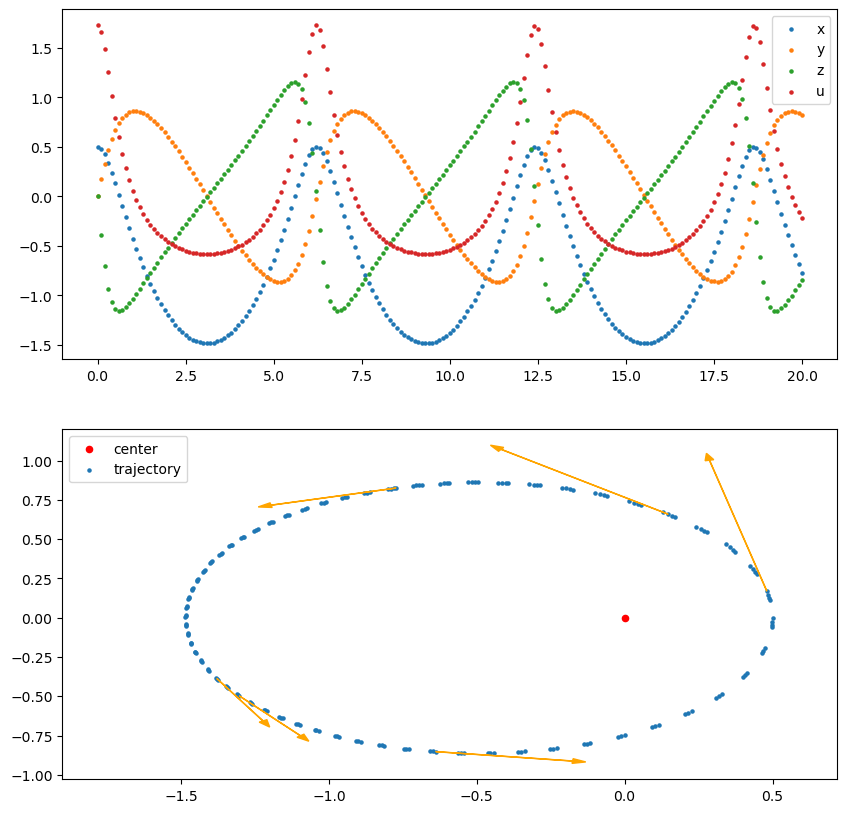

In [56]:
result_t, result_y = classicRK4( t_begin, y0, 0.1, f, t_end=t_end)
drawResult(result_t, result_y)

### Метод Адамса

In [57]:
def multistepAdams3(t0, y0, h, f, n_iter=None, t_end=None):
    '''
    3rd order Adams explicit multistep method.
    Reference: https://en.wikipedia.org/w/index.php?title=Linear_multistep_method&oldid=1182900519.
    '''

    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number."
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray."
    assert isinstance(h, numbers.Number), "h must be scalar number."
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray."
    assert n_iter is None or t_end is None, "specify n_iter or t_end."

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Two iterations have to be precalculated to start.
    # Use Runge-Kutta 4th order method.
    result_t, result_y = classicRK4( t0, y0, h, f, n_iter=2)
    result_t = list(result_t)
    result_y = list(result_y)
    saved_f  = []
    for i in range(3):
        saved_f.append(f(result_t[i], result_y[i]))

    # After two iterations we have 3 points.
    assert len(saved_f) == 3

    t = result_t[2]
    y = result_y[2]
    for i in range(2, n_iter):
        y = y + h*(23/12*saved_f[i] - 16/12*saved_f[i-1] + 5/12*saved_f[i-2])

        t += h
        result_t.append(t)
        result_y.append(y)
        saved_f.append(f(t, y))

    return np.array(result_t), np.array(result_y)


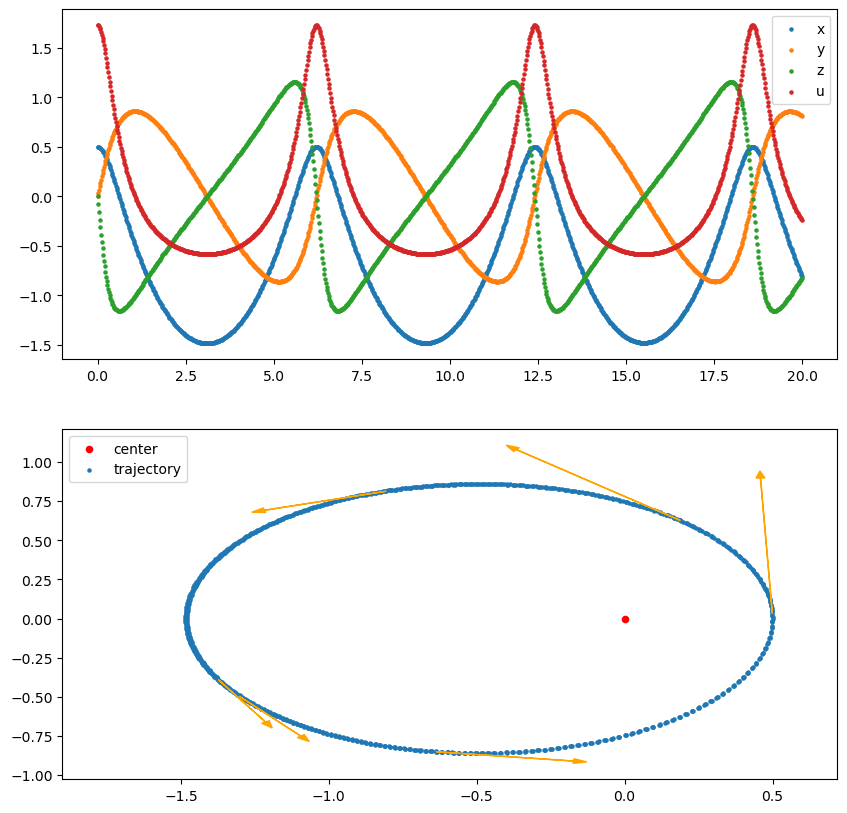

In [58]:
result_t, result_y = multistepAdams3( t_begin, y0, 0.02, f, t_end=t_end)
drawResult(result_t, result_y)

### Метод Формул Дифференцирования Назад (ФДН)

In [59]:
def BDF3(t0, y0, h, f, n_iter=None, t_end=None):
    '''
    3rd order Backward Differentiation Formula (BDF3) multistep method.

    Reference: https://en.wikipedia.org/w/index.php?title=Backward_differentiation_formula&oldid=1166087118
    '''

    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number"
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray"
    assert isinstance(h, numbers.Number), "h must be scalar number"
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray"
    assert n_iter is None or t_end is None, "specify n_iter or t_end"

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Two iterations have to be precalculated to start.
    # Use Runge-Kutta 4th order method.
    result_t, result_y = classicRK4( t0, y0, h, f, n_iter=2)

    # Guess deviation on values of initial points.
    deviation = np.max(2*np.add.accumulate(np.abs(result_y))[-1])

    result_t = list(result_t)
    result_y = list(result_y)

    t = result_t[2]
    y = result_y[2]
    for i in range(2, n_iter):
        func = lambda arg: arg - 18/11*result_y[i] + 9/11*result_y[i-1] - 2/11*result_y[i-2] - h*6/11*f(t, arg)
        y, _ = solveSystemNewton(func, y, 10, 1e-4, y-deviation, y+deviation)

        # Check obtained solution.
        y_ref = op.fsolve(func, y)
        assert np.linalg.norm(y_ref - y, ord=np.inf) < 1e-4

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)


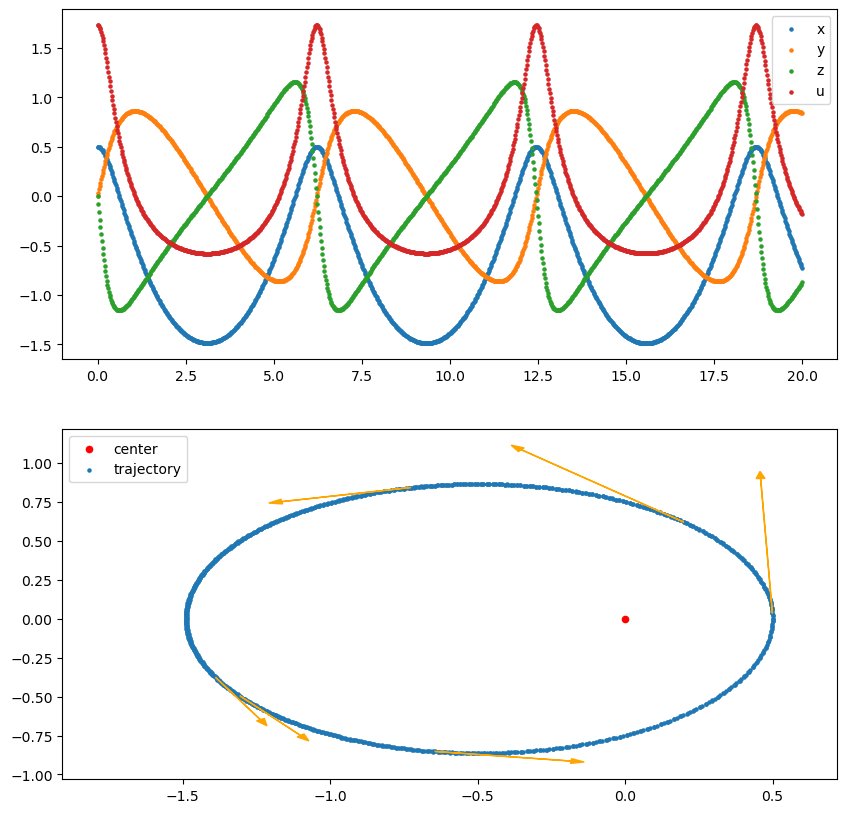

In [60]:
result_t, result_y = BDF3( t_begin, y0, 0.02, f, t_end=t_end)
drawResult(result_t, result_y)

Аристова, Завьялова, Лобанов, X.9.14

![title](res/10-9-14_task.png)

In [174]:
a = 2.0
b = 0.0015
gamma = 5.0
C = 5.0
k1 = 0.05
k2 = 0.35

t_begin = 0
t_end = 12
# y0 = np.array( [3.0, 0.34])
y0 = np.array( [3.0, 0.0525])
def f(t, y):
    assert isinstance( t, numbers.Number), "t must be scalar"
    assert type(y) is np.ndarray, "y must be ndarray"
    assert len(y) == 2, "invalid number of dimensions"

    theta0, phi0 = y0
    theta, phi = y
    result = [
        a * theta**2 / (theta + theta0) - k1*theta - gamma*theta*phi,
        b * theta * (1 - phi/C) * (1 + (phi/phi0)**2) - k2*phi,
    ]

    return np.array(result)

# Test function call
f(1, np.array([2.5, 0.03]))

array([ 1.77272727, -0.00555536])

In [175]:
def drawResult(res_t, res_y):
    fig, axes = plt.subplots(2, figsize=(10, 10))
    theta, phi = res_y.transpose()
    axes[0].plot(res_t, theta, label='theta')
    axes[0].plot(res_t, phi, label='phi')

    axes[1].plot(theta, phi, label='theta phi')

    axes[0].legend()
    axes[1].legend()

### Метод Формулы Дифференцирования назад для жесткой задачи

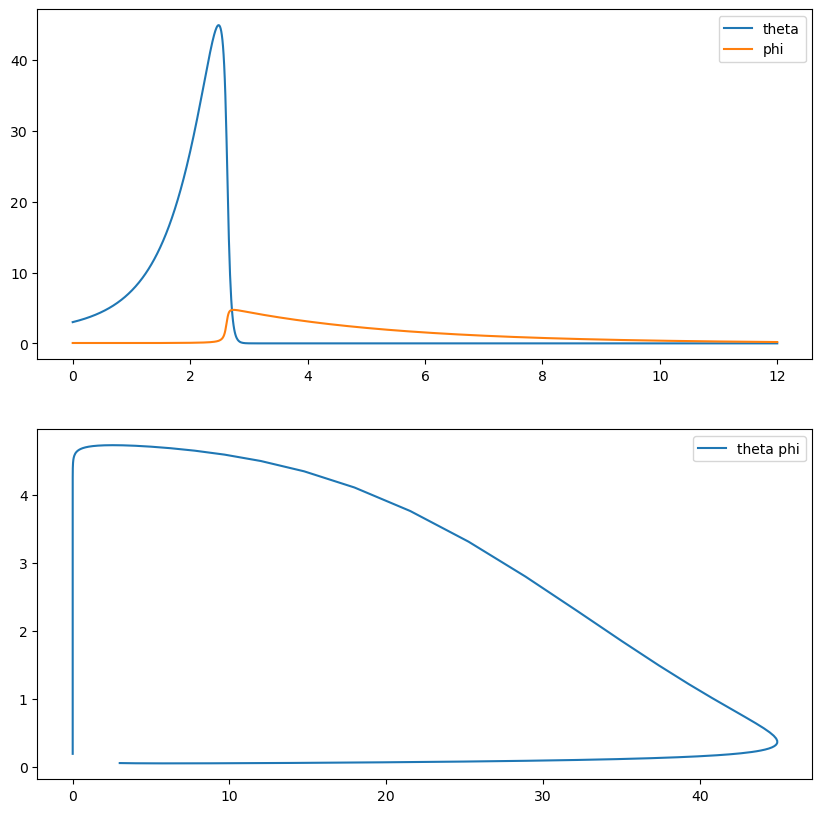

In [176]:
result_t, result_y = BDF3( t_begin, y0, 0.01, f, t_end=t_end)
drawResult(result_t, result_y)

### Неявный метод Рунге-Кутты

In [177]:
def implicitRK3(t0, y0, h, f, n_iter=None, t_end=None):
    '''
    3rd order Runge-Kutta implicit method.
    '''

    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number"
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray"
    assert isinstance(h, numbers.Number), "h must be scalar number"
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray"
    assert n_iter is None or t_end is None, "specify n_iter or t_end"

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        k1 = op.fsolve(lambda arg: arg - f(t + 1/3*h, y + h*(1/3*arg)),          y)
        k2 = op.fsolve(lambda arg: arg - f(t +     h, y + h*(1/3*k1 + 2/3*arg)), y)
        k3 = op.fsolve(lambda arg: arg - f(t +     h, y + h*(arg)),              y)
        y = y + h*(3/4*k1 + 3/4*k2 - 1/2*k3)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

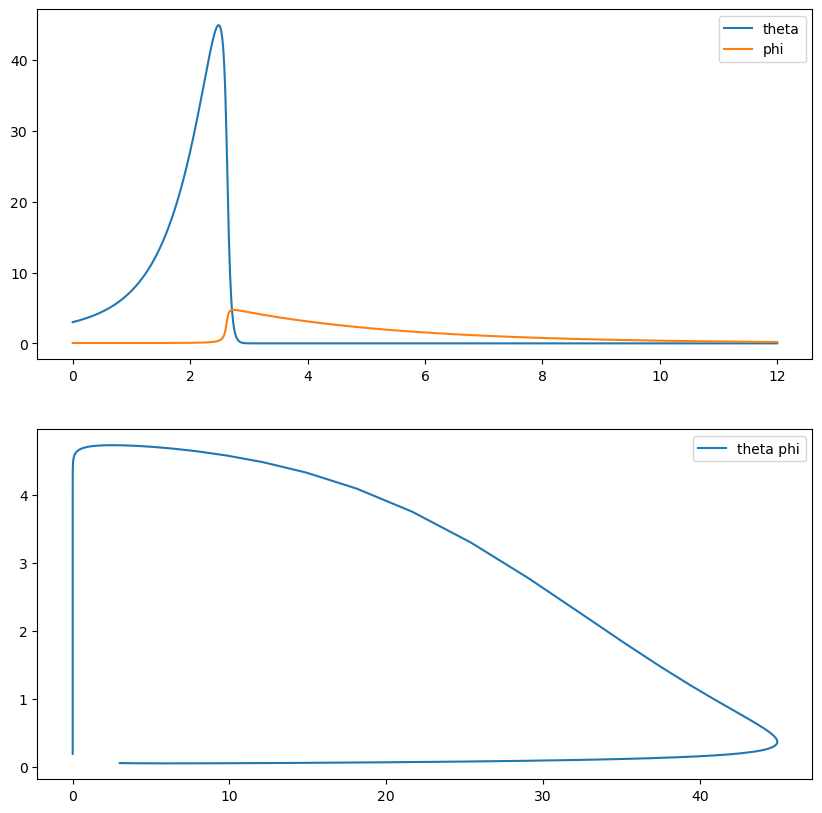

In [178]:
result_t, result_y = implicitRK3(t_begin, y0, 0.01, f, t_end=t_end)
drawResult(result_t, result_y)

### Метод Розенброка

In [179]:
def CROS(t0, y0, h, f, n_iter=None, t_end=None):
    '''
    Complex ROsenbrock Scheme.

    Reference: Al’shin, A.B., Al’shina, E.A., Kalitkin, N.N. et al.
               Rosenbrock schemes with complex coefficients for stiff and differential algebraic systems.
    '''

    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number."
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray."
    assert isinstance(h, numbers.Number), "h must be scalar number."
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray."
    assert n_iter is None or t_end is None, "specify n_iter or t_end."

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t]
    result_y = [y]

    for i in range(n_iter):
        # Get df/du Jacobian.
        J = getJacobi(lambda arg: f(t, arg), y, np.full_like(y0, 1e-6))

        # Aw = b
        b = f(t + h/2, y)
        A = (np.eye(len(y0)) - (1+1j)/2*h*J)
        w = np.linalg.solve(A, b)
        y = y + h*np.real(w)

        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

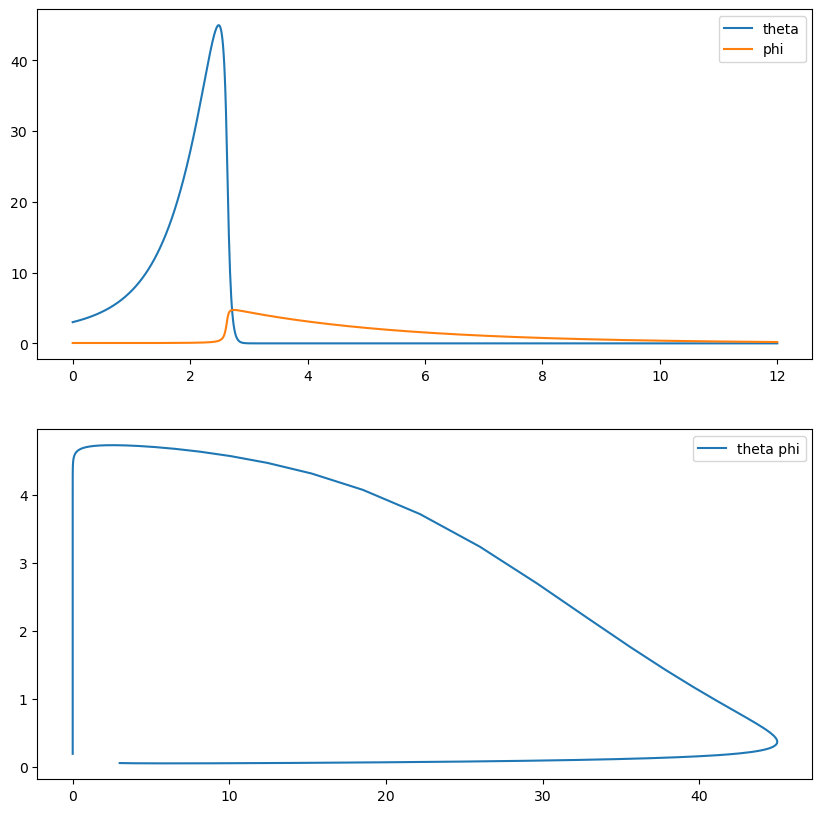

In [180]:
result_t, result_y = CROS(t_begin, y0, 0.01, f, t_end=t_end)
drawResult(result_t, result_y)

### Метод ФДН в представлении Нордсика

In [181]:
def nordsikBDF3(t0, y0, h, f, n_iter=None, t_end=None):
    '''
    Backward Differentiation Formula 3rd order multistep method in Nordsik singlestep representation.
    '''

    # Sanity checks.
    assert isinstance(t0, numbers.Number), "t0 must be scalar number."
    assert type(y0) is np.ndarray, "y0 must be numpy.ndarray."
    assert isinstance(h, numbers.Number), "h must be scalar number."
    assert type(f(t0, y0)) is np.ndarray, "function value must be numpy.ndarray."
    assert n_iter is None or t_end is None, "specify n_iter or t_end."

    if n_iter is None:
        n_iter = math.ceil((t_end - t_begin) / h)

    # Zero iteration.
    t = t0
    y = y0
    result_t = [t0]
    result_y = [y0]

    dim = 4
    P = sp.linalg.pascal(dim, kind='upper')
    l = np.array([6/11, 1, 6/11, 1/11])
    e1 = np.zeros(dim)
    e1[1] = 1
    z = np.zeros((dim, len(y0)))
    z[0] = y0

    for i in range(n_iter):
        # Case dim = 4, len(y) = 2:
        #
        # zz = PPPP zz + l (h*ff - eeee PPPP zz)
        # zz = PPPP zz   l (            PPPP zz)
        # zz = PPPP zz   l (            PPPP zz)
        # zz = PPPP zz   l (            PPPP zz)
        z = np.matmul(P, z) + np.outer(l, (h*f(t, y) - np.dot(e1, np.matmul(P, z))))

        y = z[0]
        t += h
        result_t.append(t)
        result_y.append(y)

    return np.array(result_t), np.array(result_y)

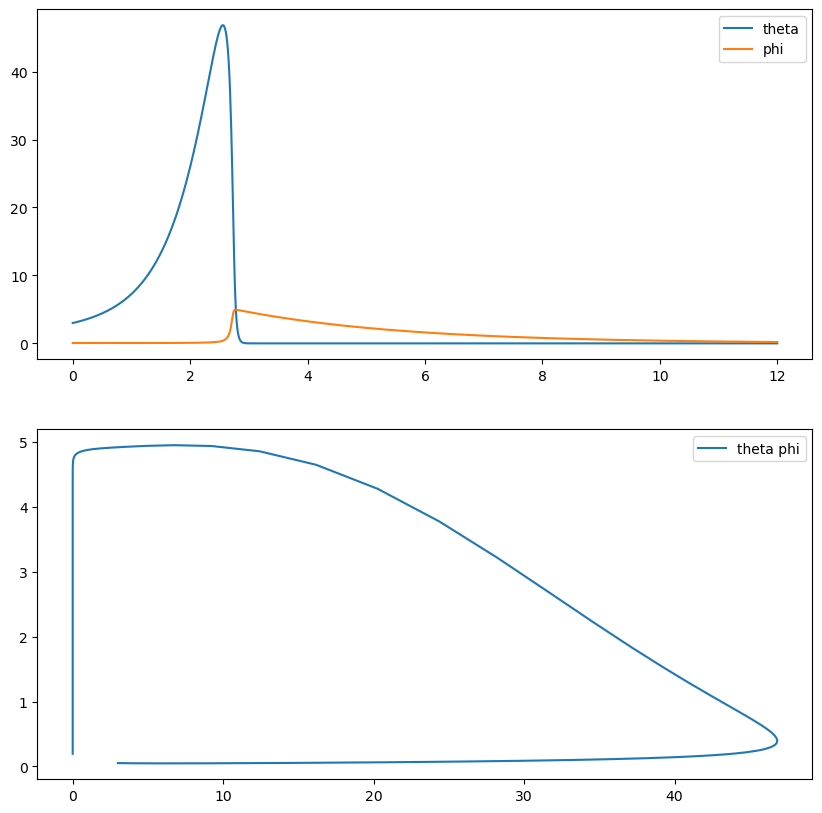

In [182]:
result_t, result_y = nordsikBDF3(t_begin, y0, 0.01, f, t_end=t_end)
drawResult(result_t, result_y)

### Сравнение методов

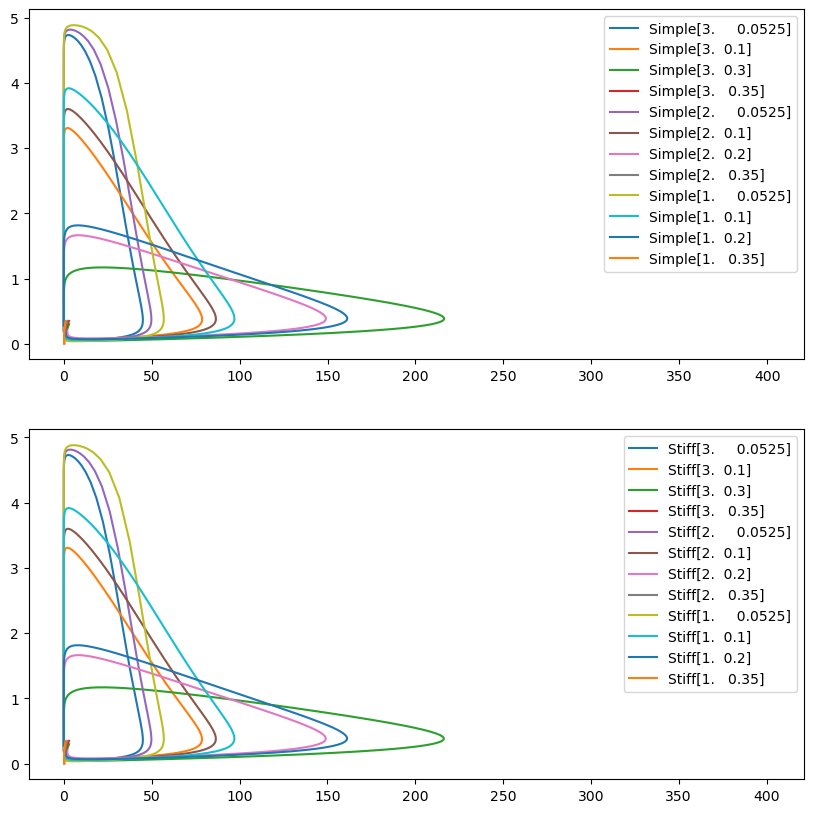

In [183]:
fig, axes = plt.subplots(2, figsize=(10, 10))
for y0 in [[3.0, 0.0525], [3.0, 0.1], [3.0, 0.3], [3.0, 0.35],
           [2.0, 0.0525], [2.0, 0.1], [2.0, 0.2], [2.0, 0.35],
           [1.0, 0.0525], [1.0, 0.1], [1.0, 0.2], [1.0, 0.35],]:
    y0 = np.array(y0)
    result_t, result_y = classicRK4( t_begin, y0, 0.01, f, t_end=t_end)
    theta, phi = result_y.transpose()
    axes[0].plot(theta, phi, label='Simple' + str(y0))
    axes[0].legend()
    xlim = axes[0].get_xlim()
    axes[0].set_xlim(xlim[0]*1.2, xlim[1]*1.2)

    result_t, result_y = CROS( t_begin, y0, 0.01, f, t_end=t_end)
    theta, phi = result_y.transpose()
    axes[1].plot(theta, phi, label='Stiff' + str(y0))
    axes[1].legend()
    xlim = axes[1].get_xlim()
    axes[1].set_xlim(xlim[0]*1.2, xlim[1]*1.2)
